In [1]:
import os
import csv
import time
import warnings
import numpy as np
import pandas as pd
warnings.simplefilter("ignore")
from sklearn.externals import joblib
plt.style.use("ggplot")
%matplotlib inline
from sklearn.metrics import auc

In [2]:
import hypopt

# Load the propressed data

In [298]:
train = pd.read_csv('./fit_train/train_final',index_col=0)

In [299]:
train.head()

,time_week_1,time_week_2,time_week_3,time_week_4,time_week_5,time_week_6,buy_week_1,buy_week_2,buy_week_3,buy_week_4,buy_week_5,buy_week_6,sumTime,sumSpend,Time_Spend,user_buy_7,user_buy_14
0,136802924.0,0.0,0.0,0.0,0.0,0.0,23.044,0.0,0.0,0.0,0.0,0.0,136802924.0,23.044,3.152487e+09,0,0
1,0.0,0.0,0.0,0.0,41422497.0,256272845.0,0.000,0.0,0.0,0.0,0.0,0.0,297695342.0,0.000,0.000000e+00,0,0
2,0.0,0.0,7536782.0,0.0,33437082.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,40973864.0,0.000,0.000000e+00,0,0
3,0.0,1728424.0,679744.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,2408168.0,0.000,0.000000e+00,0,0
4,0.0,0.0,53769987.0,319612032.0,18222574.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,391604593.0,0.000,0.000000e+00,0,0


In [9]:
val = pd.read_csv('./fit_val/fit_final',index_col=0)

In [13]:
train.user_buy_7.value_counts()

0    461297
1      4383
Name: user_buy_7, dtype: int64

In [127]:
461297/4383

105.2468628793064

In [15]:
train.user_buy_14.value_counts()

0    460053
1      5627
Name: user_buy_14, dtype: int64

In [126]:
460053/5627

81.75813044250933

In [16]:
val.user_buy_7.value_counts()

0    498607
1      4697
Name: user_buy_7, dtype: int64

In [125]:
498607/4697

106.15435384287844

In [17]:
val.user_buy_14.value_counts()

0    497243
1      6061
Name: user_buy_14, dtype: int64

In [124]:
497243/6061

82.039762415443

ratio: 105 for 7 days, 82 for 14 days

# Set up Model Matrix For Hyper-param tuning

In [36]:
X_train = train.iloc[:,:-2]

In [37]:
y_train_7 = train.iloc[:,-2]

In [38]:
y_train_14 = train.iloc[:,-1]

In [39]:
X_val = val.iloc[:,:-2]

In [40]:
y_val_7 = val.iloc[:,-2]

In [41]:
y_val_14 = val.iloc[:,-1]

# XGBOOST Hyper-param Tuning 

In [18]:
from xgboost import XGBClassifier
from hypopt import GridSearch

## For 7 days model

In [137]:
%%time
train_xgb_7 = XGBClassifier(scale_pos_weight=105, n_jobs=-1, eval_metric="auc")
param_grid1 = [
  {'learning_rate': [0.05, 0.1, 0.2, 0.3], 'max_depth':[3, 6],'n_estimators':[100, 200, 400]}
 ]
# Grid-search all parameter combinations using a validation set.
opt = GridSearch(model = train_xgb_7, param_grid=param_grid1, cv_folds=0)
opt.fit(X_train, y_train_7, X_val=X_val, y_val=y_val_7, scoring = 'roc_auc')

CPU times: user 7.98 s, sys: 7.93 s, total: 15.9 s
Wall time: 21min 40s


In [138]:
opt.best_score

0.9536082366862197

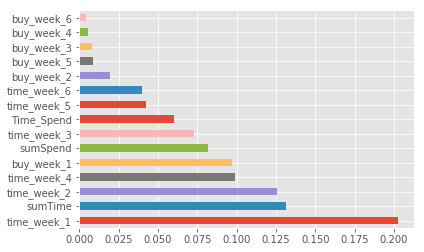

In [184]:
(pd.Series(opt.best_estimator_.feature_importances_, index=train.columns[:-2])
   .nlargest(15)
   .plot(kind='barh'))    

The ``buy_week 3-6`` seems not that useful

### Print the best hyper-params for 7 days model

In [143]:
opt.best_params

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}

## For 14 days model

In [139]:
%%time
train_xgb_14 = XGBClassifier(scale_pos_weight=82, n_jobs=-1, eval_metric="auc")
param_grid2 = [
  {'learning_rate': [0.05, 0.1, 0.2, 0.3], 'max_depth':[3, 6],'n_estimators':[100, 200, 400]}
 ]
# Grid-search all parameter combinations using a validation set.
opt2 = GridSearch(model = train_xgb_14, param_grid=param_grid2, cv_folds=0)
opt2.fit(X_train, y_train_14, X_val, y_val_14, scoring = 'roc_auc')

CPU times: user 5.99 s, sys: 5.91 s, total: 11.9 s
Wall time: 16min 37s


In [140]:
y_14_pred = opt2.predict(X_val)

In [141]:
opt2.best_score

0.9439629080265828

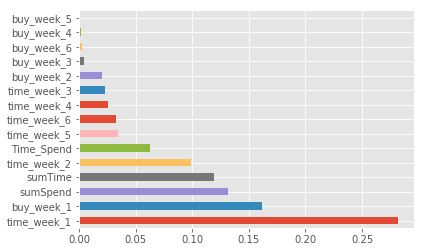

In [185]:
(pd.Series(opt2.best_estimator_.feature_importances_, index=train.columns[:-2])
   .nlargest(15)
   .plot(kind='barh'))    

Similarly, the ``buy_week 3-6`` seems not that useful

### Print the best hyper-params for 14 days model

In [144]:
opt2.best_params

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

In [153]:
(opt.best_score+opt2.best_score)/2

0.9487855723564013

if we trust the validation, the kaggle result should be around 0.95 auc on average

In [ ]:
#opt2.best_params:{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

# Refit the model on the validation to predict future

In [145]:
## 7 days

In [147]:
fit_xgb_7 = XGBClassifier(scale_pos_weight=105,
                          n_jobs=-1,
                          n_estimators = 200,
                          learning_rate=0.05,
                          max_depth = 3,
                          eval_metric = "auc")

In [148]:
%%time
fit_xgb_7.fit(X_val, y_val_7)

CPU times: user 1min 37s, sys: 455 ms, total: 1min 37s
Wall time: 1min 37s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.05,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=105, seed=None, silent=True,
       subsample=1)

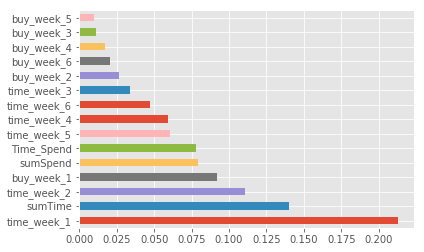

In [189]:
(pd.Series(fit_xgb_7.feature_importances_, index=train.columns[:-2])
   .nlargest(15)
   .plot(kind='barh'))  

In [149]:
## 14 days 

In [150]:
fit_xgb_14 = XGBClassifier(scale_pos_weight=82,
                           n_jobs=-1,
                           n_estimators = 100,
                           learning_rate=0.05,
                           max_depth = 3,
                           eval_metric="auc")

In [151]:
%%time
fit_xgb_14.fit(X_val, y_val_14)

CPU times: user 49.8 s, sys: 316 ms, total: 50.2 s
Wall time: 50 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.05,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=82, seed=None, silent=True,
       subsample=1)

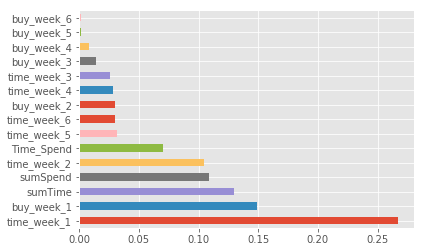

In [190]:
(pd.Series(fit_xgb_14.feature_importances_, index=train.columns[:-2])
   .nlargest(15)
   .plot(kind='barh'))  

The most closer features are more important

All importance shows ``buy_week 3,4,5,6`` are not good. Later we might consider drop them.

# Load the data to predict(Kaggle)

In [160]:
X_pred = pd.read_csv('./predict/predict_final')

In [161]:
X_pred.head()

,time_week_1,time_week_2,time_week_3,time_week_4,time_week_5,time_week_6,buy_week_1,buy_week_2,buy_week_3,buy_week_4,buy_week_5,buy_week_6,sumTime,sumSpend,Time_Spend
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1717320.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1717320.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,3041967.0,0.0,0.0,0.0,0.0,0.0,0.0,3041967.0,0.0,0.0
3,0.0,0.0,0.0,0.0,39341115.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39341115.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [162]:
y_kaggle_pred7 = fit_xgb_7.predict_proba(X_pred)[:,1]

In [163]:
y_kaggle_pred14 = fit_xgb_14.predict_proba(X_pred)[:,1]

In [164]:
sample = pd.read_csv('./rawdata/sample_submission_2.csv')

In [165]:
sample.user_purchase_binary_7_days = y_kaggle_pred7
sample.user_purchase_binary_14_days = y_kaggle_pred14

In [168]:
sample.to_csv('./luke_sub_13_xgb.csv', index=False)

In [167]:
sample.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days
0,e469dfaed039ead9110165d9bc457acb11609ca34057dc...,0.154953,0.163096
1,afcc639a324b6c598ef83d360450afa011cb2dd1358bf9...,0.037762,0.065844
2,fd5a7cf211d08e3e00f7be6a9df6e6ea3d2e5c22a5d9c3...,0.030857,0.059815
3,00bfff98b9d0329f014c2eeac7ce47cd18b2bc6e10d608...,0.053470,0.077220
4,0d298f3638c43e915c119d4935e1ce8d168f81b5e3e8c1...,0.154953,0.163096


In [ ]:
#!kaggle competitions submit -c predict-in-app-purchase -f ./luke_sub_12_xgb.csv -m [sub]

In [193]:
from sklearn.neural_network import MLPClassifier

In [275]:
count = y_train_7.value_counts()[1]

In [276]:
newx = X_train[y_train_7==1]

In [277]:
down = X_train[y_train_7==0].sample(count)

In [278]:
new = pd.concat([newx,down])

In [283]:
new_y = [1]*count+[0]*count

In [284]:
#7

In [285]:
clf6 = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(12,8,4,2), random_state=1)
scaler = StandardScaler()
pipe6 = Pipeline(steps=[('scaler',scaler),('mlp', clf6)])

In [286]:
%%time
pipe6.fit(new, new_y)#X_train, y_train_7, X_val=X_val, y_val=y_val_7

CPU times: user 15.9 s, sys: 89.5 ms, total: 16 s
Wall time: 4.01 s


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp', MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(12, 8, 4, 2), learning_rate='constant',
       learni...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))])

In [287]:
nn_pred = pipe6.predict(X_val)

In [288]:
fpr, tpr, thresholds = roc_curve(y_val_7, nn_pred, pos_label=1)
auc(fpr, tpr)

0.8708114643889253

In [252]:
#14

In [289]:
pipe7 = Pipeline(steps=[('scaler',scaler),('mlp', clf6)])

In [290]:
count = y_train_14.value_counts()[1]

In [291]:
newx = X_train[y_train_14==1]

In [292]:
down = X_train[y_train_14==0].sample(count)

In [293]:
new = pd.concat([newx,down])

In [294]:
new_y = [1]*count+[0]*count

In [295]:
%%time
pipe7.fit(new, new_y)#X_train, y_train_7, X_val=X_val, y_val=y_val_7

CPU times: user 22.7 s, sys: 186 ms, total: 22.8 s
Wall time: 5.74 s


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp', MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(12, 8, 4, 2), learning_rate='constant',
       learni...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))])

In [296]:
nn_pred = pipe7.predict(X_val)

In [297]:
fpr, tpr, thresholds = roc_curve(y_val_14, nn_pred, pos_label=1)
auc(fpr, tpr)

0.8647175125191203

not good

# Stacking

In [146]:
#later when we have more robust models and more features